##  <center>ITU / FIZ 437E </center>
##    <center> Statistical Learning from Data: Applications in Physics </center>
### **<center> Homework I Question 2 Solutions (SGD) </center>**

Gökay AKÇAY **090200147**

Burak Berk Cihan **090200161**

Ege Tan Tüzüner **090200131**

Umut Kaya **090190149**





### Used Libraries

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score

from sklearn import __version__ as sklearn_version

from scipy.interpolate import RegularGridInterpolator

from scipy import __version__ as scipy_version
from scipy import stats
import math

In [13]:
!pip show pandas matplotlib numpy seaborn scikit-learn scipy | findstr "Name \| Version "

zsh:1: command not found: findstr
ERROR: Pipe to stdout was broken
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe


### Defining the Function

Create a 2D grid with coordinates changing from −8 to 8 for each dimension with a step size of 0.1 and
evaluate the function

In [14]:
step_size = 0.1

def f(x,y):
    return 1.8 - np.exp(-1 * 0.1*(2.5 *(x + 3)**2 + (y+3)**2)) - 1.5 * np.exp((-0.05 * (2.5 * (x - 3)**2 + (y-3)**2)))


x = np.arange(-8,8,step_size)
y = np.arange(-8,8,step_size)

z = np.arange(-8,8,step_size)

xg, yg = np.meshgrid(x, y, indexing='ij', sparse=True)

zg = f(xg,yg)

In [15]:
zg.shape

(160, 160)

## Visualization

#### Function Graph

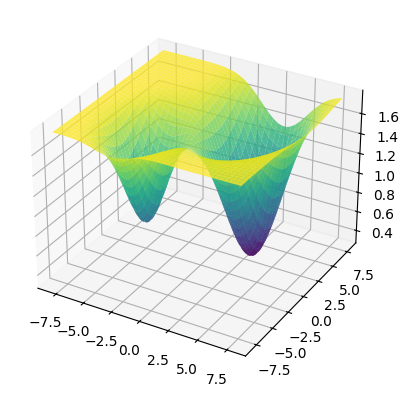

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(xg, yg, zg, cmap='viridis', alpha=0.8)


Function has one local minimum and one absolute minimum

#### Grid Interpolation & Gradient Visualization

The grid were interpolated to show much more smooth changes on gradient

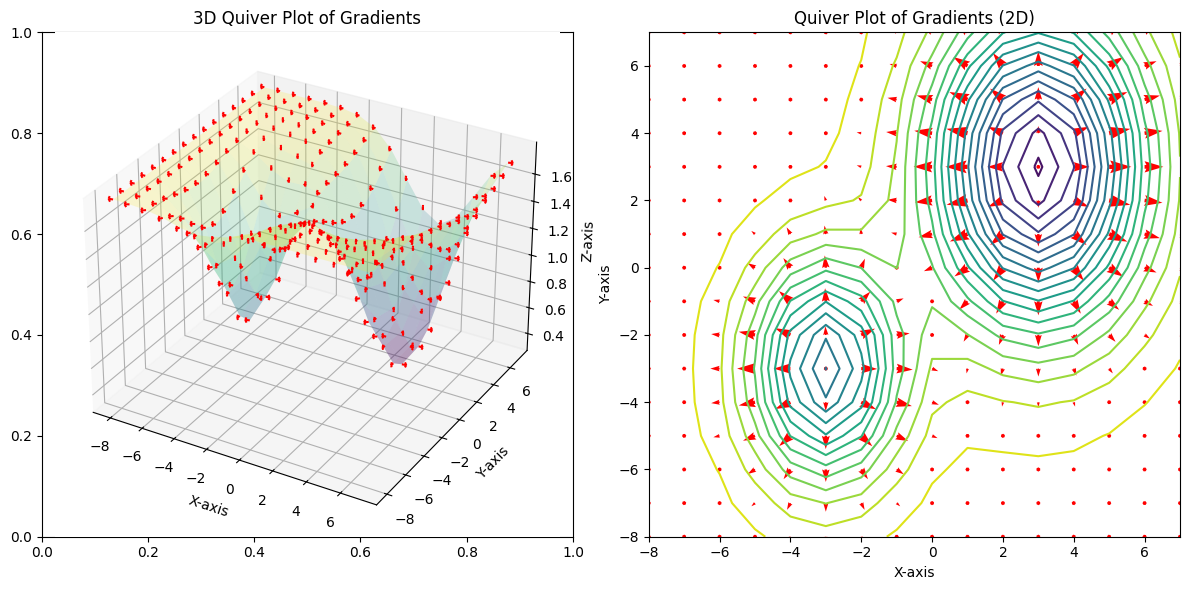

In [17]:

x_plot = np.arange(-8,8,step_size*10)
y_plot = np.arange(-8,8,step_size*10)

xg,yg = np.meshgrid(x_plot, y_plot, indexing='ij')

data = f(xg,yg)

# Interpolate the data on the finer grid
interp = RegularGridInterpolator((x_plot, y_plot), data, bounds_error=False, fill_value=None)

data_interp = interp((xg,yg))

grad_x, grad_y = np.gradient(data_interp,axis=(0,1))

# Compute the gradient on the finer grid

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0] = fig.add_subplot(121, projection='3d')


axs[0].plot_surface(xg, yg, data, cmap='viridis', alpha=0.2)  # Surface plot of the original data
axs[0].quiver(xg, yg, data, grad_x, grad_y, np.zeros_like(grad_x), color='red', length=0.25, normalize=True)  # 3D quiver plot of the gradients
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')
axs[0].set_zlabel('Z-axis')
axs[0].set_title('3D Quiver Plot of Gradients')


# Plot 2D quiver plot on the second subplot
axs[1].contour(xg, yg, data, levels=20, cmap='viridis')  # Contour plot of the original data
axs[1].quiver(xg, yg, grad_x, grad_y, scale=10, color='red', width=0.008)  # Quiver plot of the gradients
axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Y-axis')
axs[1].set_title('Quiver Plot of Gradients (2D)')

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

### Implementing GD

In [18]:
class GD:
    def __init__(self,lr=0.1,max_iter = 1500, tol=1e-03,theta_init = 0.1):
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.theta = theta_init
        
    def get_interpolated_gradient(self,x,y):      
        xg, yg = np.meshgrid(x, y, indexing='ij')  
        data = f(xg,yg)
        
        interp = RegularGridInterpolator((x, y), data, bounds_error=False, fill_value=None)
        data_interp = interp((xg,yg))
        df_dx, df_dy = np.gradient(data_interp,axis=(0, 1))
        
        return df_dx,df_dy
        
    def get_point_gradient(self,x_point,y_point):

        num_points = 2
        x_points = np.linspace(x_point - 1, x_point + 1, num_points)
        y_points = np.linspace(y_point - 1, y_point + 1, num_points)
        
        x_grid, y_grid = np.meshgrid(x_points, y_points)
        z_grid = f(x_grid, y_grid)
    
        # Create the interpolator
    
        interp = RegularGridInterpolator((x_points, y_points), z_grid, bounds_error=False, fill_value=None)
        
        # Specify the point where you want to compute the gradient
        
        # Interpolate the function value at the specified point
        z_at_point = interp((x_point, y_point))
        
        # Compute the gradient using numpy.gradient
        df_dx, df_dy = np.gradient(z_grid, axis=(1, 0))
        
        # Interpolate the gradient values at the specified point
        grad_x_at_point = np.interp(x_point, x_points, df_dx[:, 0])  # Interpolate along the x-axis
        grad_y_at_point = np.interp(y_point, y_points, df_dy[0, :])  # Interpolate along the y-axis
        
    
        #print(f"Gradient at ({x_point}, {y_point}): ({grad_x_at_point}, {grad_y_at_point})")   
        # REMOVE THIS TO SHOW GRADIENTS AT EACH POINT
        
        return grad_x_at_point , grad_y_at_point
           
    def descend(self,X,y,start_point):
        
        point_history = [start_point]
        
        xg, yg = np.meshgrid(X, y, indexing='ij')
        
        df_dx,df_dy = self.get_interpolated_gradient(X,y)
        
        for i in range(0,self.max_iter):
            
            x_point = start_point[0]
            y_point = start_point[1]
              
            grads = self.get_point_gradient(x_point,y_point)
                     
            xhat_point = x_point - self.lr * grads[0]
            yhat_point = y_point - self.lr * grads[1]    
            start_point = (xhat_point,yhat_point)
            
            point_history.append(start_point)
        
        return np.asarray(point_history)

In [ ]:
gd = GD()
history_1 = gd.descend(x,y,(1,-7))
history_2 = gd.descend(x,y,(2,-5))
history_3 = gd.descend(x,y,(5,-1))

History, shows the points which their gradients were taken

Now lets do it for 3 points

### Visualization 2D

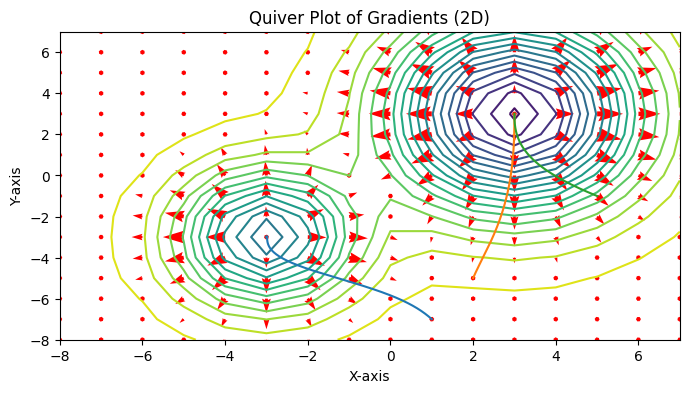

In [13]:
# Plot 2D quiver plot on the second subplot
fig, ax = plt.subplots(figsize=(8, 4))


ax.contour(xg, yg, data, levels=20, cmap='viridis')  # Contour plot of the original data
ax.quiver(xg, yg, grad_x, grad_y, scale=10, color='red', width=0.008)  # Quiver plot of the gradients
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Quiver Plot of Gradients (2D)')

ax.plot(history_1[:,0],history_1[:,1])

ax.plot(history_2[:,0],history_2[:,1])

ax.plot(history_3[:,0],history_3[:,1])


### Visualization on 3D

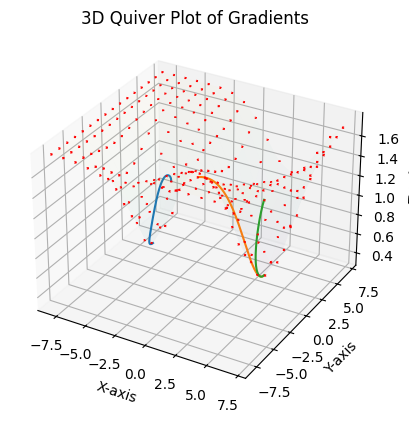

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(xg, yg, data, cmap='viridis', alpha=0.02)  # Surface plot of the original data
ax.quiver(xg, yg, data, grad_x, grad_y, np.zeros_like(grad_x), color='red', length=0.11, normalize=True)  # 3D quiver plot of the gradients
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Quiver Plot of Gradients')

ax.plot(history_1[:,0],history_1[:,1] , f(history_1[:,0],history_1[:,1]))

ax.plot(history_2[:,0],history_2[:,1], f(history_2[:,0],history_2[:,1]))

ax.plot(history_3[:,0],history_3[:,1], f(history_3[:,0],history_3[:,1]))
